In [39]:
import argparse
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score, average_precision_score
import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import RGCNConv
from torch_geometric.loader import ClusterData, ClusterLoader
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm, trange
import gc
import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

gc.collect()

2682

In [40]:
hetero_data = torch.load('../data/model/hetero_graph_data.pt')

In [3]:
hetero_data

HeteroData(
  customer={
    x=[161086, 12],
    index=[161086],
  },
  product={
    x=[2708, 15],
    index=[2708],
  },
  (customer, order, product)={ edge_index=[2, 11892915] },
  (product, class, product)={ edge_index=[2, 1796620] },
  (product, rev_class, product)={ edge_index=[2, 1796620] },
  (product, rev_order, customer)={ edge_index=[2, 11892915] }
)

In [41]:
train_data, val_data, test_data = T.RandomLinkSplit(
        num_val=0.2,
        num_test=0.2,
        is_undirected=True,
        add_negative_train_samples=True,
        disjoint_train_ratio=0,
        edge_types=[('customer', 'order', 'product'),
                    ('product', 'class', 'product')],
        rev_edge_types=[('product', 'rev_order', 'customer'), 
                        ('product', 'rev_class', 'product')]
    )(hetero_data.to_homogeneous())
# 产品节点特征本来是12，被0填充到15了，与客户节点对齐

In [42]:
train_loader = ClusterLoader(ClusterData(train_data, num_parts=128), batch_size=32)  # 训练集太大，分批量

Computing METIS partitioning...
Done!


In [43]:
def negative_sample(data):
    # 从训练集中采样与正边相同数量的负边
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index, num_nodes=data.num_nodes,
        num_neg_samples=data.edge_label_index.size(1), method='sparse')
    # print(neg_edge_index.size(1))   # 3642条负边，即每次采样与训练集中正边数量一致的负边
    edge_label_index = torch.cat(
        [data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        data.edge_label,
        data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    return edge_label, edge_label_index

In [44]:
# 定义参数
node_types = train_data.node_type.unique().cpu().tolist()  # 变同质图后，被标记为0（客户）和1（商品）
num_relations = len(hetero_data.edge_types)
init_sizes = [train_data.x[train_data.node_type==1].shape[-1] for i in node_types]  # 变同质图之后其实都是一样的
# init_x = [hetero_data[node_type].x.to(device) for node_type in node_types]
in_feats = 16  # 直接指定即可，RGCN中有一个线性层转化输出统一到此维度
hidden_feats = 32  # 隐藏层，直接指定即可
out_channels = 16  # 输出层，直接指定，最终输出的解码器的输入维度是 2*out_channels

In [55]:
class RGCN_LP(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5, reg_lambda=0.01):
        super(RGCN_LP, self).__init__()
        self.dropout = dropout
        self.reg_lambda = reg_lambda
        self.conv1 = RGCNConv(in_channels, hidden_channels,
                              num_relations=num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels,
                              num_relations=num_relations)
        self.lins = torch.nn.ModuleList()
        for i in range(len(node_types)):
            lin = nn.Linear(init_sizes[i], in_channels)
            self.lins.append(lin)

        self.fc = nn.Sequential(
            nn.Linear(2 * out_channels, 1),
            nn.Sigmoid()
        )

    def trans_dimensions(self, xs):
        res = []
        for x, lin in zip(xs, self.lins):
            res.append(lin(x))
        return torch.cat(res, dim=0)

    def encode(self, data):
        x = [data.x[data.node_type == node_type] for node_type in node_types]
        x = self.trans_dimensions(x)
        edge_index, edge_type = data.edge_index, data.edge_type
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_type)
        return x

    def decode(self, z, index):
        # print(z.shape)
        src = z[index[0]]
        dst = z[index[1]]
        x = torch.cat([src, dst], dim=-1)
        x = self.fc(x)
        return x

    def forward(self, data, index):
        z = self.encode(data)
        z = self.decode(z, index)
        return z
    
    def l2_regularization(self):
        l2_reg = torch.tensor(0.0, device=device)
        for param in self.parameters():
            l2_reg += torch.norm(param, p=2)
        return self.reg_lambda * l2_reg

In [56]:
def get_metrics(out, label):
    auc = roc_auc_score(label.cpu().numpy(), out.cpu().numpy())
    ap = average_precision_score(label.cpu().numpy(), out.cpu().numpy())
    return auc, ap

In [68]:
def train():
    model = RGCN_LP(in_feats, hidden_feats, out_channels, 0, 0.03).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
    criterion = torch.nn.BCELoss().to(device)
    min_epochs = 10
    min_val_loss = np.Inf
    summary = {'train_loss': [], 'val_loss': [], 'test_auc': [], 'test_avg_pre': []}
    # epoch_count = 0
    model.train()  # 设定模型为可训练
    val_data.to(device)
    test_data.to(device)
    for epoch in trange(40):
        for train_batch in train_loader:
            train_batch.to(device)
            optimizer.zero_grad()
            # edge_label, edge_label_index = negative_sample(train_batch)
            out = model(train_batch, train_batch.edge_index).view(-1)
            loss = criterion(out, train_batch.edge_label) + model.l2_regularization()
            loss.backward()
            optimizer.step()
        # validation
        val_loss, test_auc, test_ap = test(model, val_data, test_data)
        summary['train_loss'].append(loss.item())
        summary['val_loss'].append(val_loss)
        summary['test_auc'].append(test_auc)
        summary['test_avg_pre'].append(test_ap)
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss

        print('epoch {:03d} train_loss {:.4f} val_loss {:.4f} test_auc {:.4f} test_avg_precision {:.4f}'
              .format(epoch, loss.item(), val_loss, test_auc, test_ap))
    summary = pd.DataFrame(summary)
    summary.to_csv('../data/result/pyg_link_pre.csv', index=False, encoding='utf-8-sig')
    return summary

@torch.no_grad()
def test(model, val_data, test_data):
    model.eval()  # 设定模型不可训练
    # cal val loss
    criterion = torch.nn.BCELoss().to(device)
    out = model(val_data, val_data.edge_label_index).view(-1)
    val_loss = criterion(out, val_data.edge_label)
    # cal metrics
    out = model(test_data, test_data.edge_label_index).view(-1)
    model.train()

    auc, ap = get_metrics(out, test_data.edge_label)

    return val_loss.item(), auc, ap

In [69]:
summary = train()

  2%|▎         | 1/40 [00:03<02:18,  3.55s/it]

epoch 000 train_loss 1.3757 val_loss 0.6232 test_auc 0.8640 test_avg_precision 0.9156


  5%|▌         | 2/40 [00:06<02:08,  3.37s/it]

epoch 001 train_loss 0.9183 val_loss 0.5582 test_auc 0.8696 test_avg_precision 0.9248


  8%|▊         | 3/40 [00:10<02:04,  3.36s/it]

epoch 002 train_loss 0.8157 val_loss 0.5705 test_auc 0.8699 test_avg_precision 0.9255


 10%|█         | 4/40 [00:13<01:59,  3.33s/it]

epoch 003 train_loss 0.7397 val_loss 0.6278 test_auc 0.9102 test_avg_precision 0.9416


 12%|█▎        | 5/40 [00:16<01:56,  3.33s/it]

epoch 004 train_loss 0.6977 val_loss 0.5744 test_auc 0.9555 test_avg_precision 0.9657


 15%|█▌        | 6/40 [00:20<01:53,  3.35s/it]

epoch 005 train_loss 0.6202 val_loss 0.5040 test_auc 0.8762 test_avg_precision 0.9275


 18%|█▊        | 7/40 [00:23<01:51,  3.39s/it]

epoch 006 train_loss 0.5838 val_loss 0.5348 test_auc 0.8684 test_avg_precision 0.9226


 20%|██        | 8/40 [00:26<01:48,  3.38s/it]

epoch 007 train_loss 0.5547 val_loss 0.5557 test_auc 0.8684 test_avg_precision 0.9219


 22%|██▎       | 9/40 [00:30<01:46,  3.43s/it]

epoch 008 train_loss 0.5319 val_loss 0.5544 test_auc 0.8723 test_avg_precision 0.9249


 25%|██▌       | 10/40 [00:34<01:44,  3.47s/it]

epoch 009 train_loss 0.5034 val_loss 0.5487 test_auc 0.8760 test_avg_precision 0.9267


 28%|██▊       | 11/40 [00:37<01:41,  3.51s/it]

epoch 010 train_loss 0.4700 val_loss 0.5500 test_auc 0.8792 test_avg_precision 0.9279


 30%|███       | 12/40 [00:41<01:38,  3.50s/it]

epoch 011 train_loss 0.4421 val_loss 0.5476 test_auc 0.8825 test_avg_precision 0.9284


 32%|███▎      | 13/40 [00:44<01:33,  3.45s/it]

epoch 012 train_loss 0.4190 val_loss 0.5319 test_auc 0.8812 test_avg_precision 0.9280


 35%|███▌      | 14/40 [00:47<01:29,  3.44s/it]

epoch 013 train_loss 0.3985 val_loss 0.5334 test_auc 0.8744 test_avg_precision 0.9248


 38%|███▊      | 15/40 [00:51<01:25,  3.40s/it]

epoch 014 train_loss 0.3781 val_loss 0.5381 test_auc 0.8687 test_avg_precision 0.9225


 40%|████      | 16/40 [00:54<01:20,  3.35s/it]

epoch 015 train_loss 0.3582 val_loss 0.5399 test_auc 0.8672 test_avg_precision 0.9226


 42%|████▎     | 17/40 [00:57<01:16,  3.32s/it]

epoch 016 train_loss 0.3408 val_loss 0.5431 test_auc 0.8669 test_avg_precision 0.9222


 45%|████▌     | 18/40 [01:01<01:13,  3.32s/it]

epoch 017 train_loss 0.3247 val_loss 0.5441 test_auc 0.8669 test_avg_precision 0.9221


 48%|████▊     | 19/40 [01:04<01:08,  3.27s/it]

epoch 018 train_loss 0.3101 val_loss 0.5426 test_auc 0.8669 test_avg_precision 0.9221


 50%|█████     | 20/40 [01:07<01:04,  3.24s/it]

epoch 019 train_loss 0.2969 val_loss 0.5414 test_auc 0.8669 test_avg_precision 0.9221


 52%|█████▎    | 21/40 [01:10<01:01,  3.24s/it]

epoch 020 train_loss 0.2849 val_loss 0.5372 test_auc 0.8668 test_avg_precision 0.9221


 55%|█████▌    | 22/40 [01:13<00:57,  3.20s/it]

epoch 021 train_loss 0.2743 val_loss 0.5312 test_auc 0.8669 test_avg_precision 0.9222


 57%|█████▊    | 23/40 [01:16<00:54,  3.21s/it]

epoch 022 train_loss 0.2659 val_loss 0.5265 test_auc 0.8670 test_avg_precision 0.9223


 60%|██████    | 24/40 [01:20<00:51,  3.20s/it]

epoch 023 train_loss 0.2586 val_loss 0.5237 test_auc 0.8674 test_avg_precision 0.9225


 62%|██████▎   | 25/40 [01:23<00:48,  3.21s/it]

epoch 024 train_loss 0.2512 val_loss 0.5232 test_auc 0.8679 test_avg_precision 0.9227


 65%|██████▌   | 26/40 [01:26<00:45,  3.22s/it]

epoch 025 train_loss 0.2448 val_loss 0.5243 test_auc 0.8686 test_avg_precision 0.9231


 68%|██████▊   | 27/40 [01:29<00:41,  3.21s/it]

epoch 026 train_loss 0.2392 val_loss 0.5253 test_auc 0.8694 test_avg_precision 0.9235


 70%|███████   | 28/40 [01:32<00:38,  3.21s/it]

epoch 027 train_loss 0.2339 val_loss 0.5261 test_auc 0.8702 test_avg_precision 0.9238


 72%|███████▎  | 29/40 [01:36<00:35,  3.21s/it]

epoch 028 train_loss 0.2293 val_loss 0.5257 test_auc 0.8703 test_avg_precision 0.9238


 75%|███████▌  | 30/40 [01:39<00:32,  3.22s/it]

epoch 029 train_loss 0.2249 val_loss 0.5263 test_auc 0.8711 test_avg_precision 0.9240


 78%|███████▊  | 31/40 [01:42<00:29,  3.23s/it]

epoch 030 train_loss 0.2209 val_loss 0.5247 test_auc 0.8725 test_avg_precision 0.9244


 80%|████████  | 32/40 [01:45<00:25,  3.23s/it]

epoch 031 train_loss 0.2172 val_loss 0.5243 test_auc 0.8734 test_avg_precision 0.9246


 82%|████████▎ | 33/40 [01:49<00:22,  3.25s/it]

epoch 032 train_loss 0.2139 val_loss 0.5242 test_auc 0.8749 test_avg_precision 0.9249


 85%|████████▌ | 34/40 [01:52<00:19,  3.26s/it]

epoch 033 train_loss 0.2109 val_loss 0.5248 test_auc 0.8769 test_avg_precision 0.9254


 88%|████████▊ | 35/40 [01:55<00:16,  3.25s/it]

epoch 034 train_loss 0.2085 val_loss 0.5254 test_auc 0.8777 test_avg_precision 0.9257


 90%|█████████ | 36/40 [01:58<00:12,  3.23s/it]

epoch 035 train_loss 0.2067 val_loss 0.5256 test_auc 0.8788 test_avg_precision 0.9260


 92%|█████████▎| 37/40 [02:02<00:09,  3.24s/it]

epoch 036 train_loss 0.2052 val_loss 0.5253 test_auc 0.8818 test_avg_precision 0.9269


 95%|█████████▌| 38/40 [02:05<00:06,  3.24s/it]

epoch 037 train_loss 0.2035 val_loss 0.5248 test_auc 0.8892 test_avg_precision 0.9291


 98%|█████████▊| 39/40 [02:08<00:03,  3.26s/it]

epoch 038 train_loss 0.2021 val_loss 0.5251 test_auc 0.8991 test_avg_precision 0.9323


100%|██████████| 40/40 [02:12<00:00,  3.30s/it]

epoch 039 train_loss 0.2007 val_loss 0.5252 test_auc 0.9028 test_avg_precision 0.9336


<Axes: >

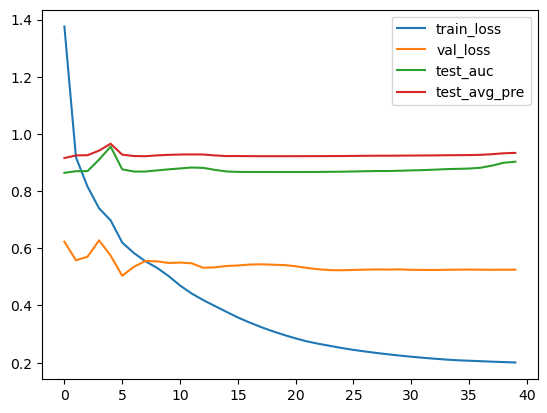

In [70]:
summary.plot()